**Objective:** 

- Create a synthetic problem with topography
- Generate an Octree mesh with the builder tools
- Invert mag data with MVI-Cartesian
- Finish inversion with MVI-Spherical

In [1]:
%matplotlib notebook
# %pylab

In [2]:
from SimPEG import (Mesh, Directives, Maps, 
                    InvProblem, Optimization, DataMisfit, 
                    Inversion, Utils, Regularization)

import SimPEG.PF as PF
from SimPEG.Utils import mkvc
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import vtki

In [3]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000., 90., 0.)

# Set magnetization M (dip, azm)
M = np.array([45,45])

# Create a mesh
h = [5,5,5]
padDist = np.ones((3,2)) * 100

# Create grid of points for topography
# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(np.linspace(-200,200,50), np.linspace(-200,200,50))
b = 100
A = 50
zz = A*np.exp(-0.5*((xx/b)**2. + (yy/b)**2.))

# We would usually load a topofile
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Create and array of observation points
xr = np.linspace(-100., 100., 20)
yr = np.linspace(-100., 100., 20)
X, Y = np.meshgrid(xr, yr)
Z = A*np.exp(-0.5*((X/b)**2. + (Y/b)**2.)) + 5

# Create a MAGsurvey
# components= ["dbz_dz", "tmi"]
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField, components=["dbz_dz", "tmi"]) 

# Create a topography
mesh = Utils.modelutils.meshBuilder(topo, h, padDist,
                                    meshType='TREE', meshGlobal=None,
                                    verticalAlignment='center')

# Refine the mesh around topography
mesh = Utils.modelutils.refineTree(mesh, topo, dtype='surface',
                                   octreeLevels=[0, 5, 3], finalize=True)

# mesh = Utils.modelutils.refineTree(mesh, xyzLoc, dtype='surface',
#                                    nCpad=[2, 0, 0], finalize=True)


# Define an active cells from topo
actv = Utils.surface2ind_topo(mesh, topo)
nC = int(actv.sum())
Mesh.TreeMesh.writeUBC(mesh, 'OctreeMesh.msh',
                               models={'ActiveOctree.dat': actv})

**OPTIONAL FOR EQUIVALENT SOURCE**


In [4]:
# Here how the topo looks with a quick interpolation, just a Gaussian...
# tri = sp.spatial.Delaunay(topo)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.plot_trisurf(topo[:,0], topo[:,1], topo[:,2], triangles=tri.simplices, cmap=plt.cm.Spectral)
# ax.scatter3D(xyzLoc[:,0],xyzLoc[:,1],xyzLoc[:,2], c='k')
# ax.set_aspect(1./4)
# plt.show()



**The following function is just for plotting vector models**

Copy of discretize.TreeMesh.plotSlice and adapt for vector model

**Create the MVI problem and pair with survey**

In [5]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = nC*3)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(
    mesh, chiMap = idenMap, actInd = actv, modelType='vector'
)

# Pair the survey and problem
survey.pair(prob)



In [6]:
# We can now create a susceptibility model and generate data
# Lets start with a simple block in half-space
# model = Utils.ModelBuilder.addBlock(mesh.gridCC, np.zeros(mesh.nC), np.r_[-40,-40,-50], np.r_[40,40,0], 0.05)[actv]

model = np.zeros((mesh.nC, 3))

# first Block magnetized down towards West
ind = Utils.ModelBuilder.getIndicesBlock(
    np.r_[-20, -20, -10], np.r_[20, 20, 25],
    mesh.gridCC,
)[0]
model[ind,:] = np.kron(np.ones((ind.shape[0],1)), Utils.matutils.dipazm_2_xyz(M[0],M[1])*0.05)

# # Second Block magnetized up towards West
# ind = Utils.ModelBuilder.getIndicesBlock(
#     np.r_[20, -20, -10], np.r_[55, 20, 25],
#     mesh.gridCC,
# )[0]
# model[ind,:] = np.kron(np.ones((ind.shape[0],1)), np.c_[0, 0, -1]*0.05)

# Remove air cells
model = model[actv,:]

In [7]:
# import vtki
vtki.set_plot_theme('document')

def plotVtki(model, plotter, factor=300, clim = [0., 0.005], cam_position=None, figName='Slice', export='figure', finalize=True):
    arrow_geom = vtki.Arrow(tip_length=1)
    # arrow_geom = vtki.Cone()
    model.reshape((nC, 3), order="F").shape
    dataset = mesh.toVTK()

    vectors = np.empty((mesh.nC, 3))
    vectors[np.argwhere(actv).flatten(), :] = model.reshape((nC, 3), order="F")

    dataset.cell_arrays['Vectors'] = vectors
    dataset.cell_arrays['Magnitude'] = np.linalg.norm(vectors, axis=1)
    dataset.cell_arrays['Active'] = actv#np.load('active.npy').astype(int)
    dataset.active_scalar_name = 'Magnitude'
    dataset.active_vectors_name = 'Vectors'
    dataset = dataset.threshold(0.5, scalars='Active')

    # Get several slices of the mesh
    slices = dataset.slice_along_axis(n=5, axis='x')
    # Create arrows on those slices
    arrows = vtki.MultiBlock()
    for slc in slices:
        a = slc.cell_centers().glyph(orient=True, geom=arrow_geom, factor=factor)
        arrows.append(a)


    # Plot it up!
    d_params = dict(
        rng=clim,
        show_edges=True,
        cmap='viridis',
        scalars='Magnitude',
    )

     
    plotter.show_grid(all_edges=False,)

    # Add all the slices
    plotter.add_mesh(slices[2], name='slices', **d_params)
    # Add the vectors
    plotter.add_mesh(arrows[2], name='arrows', **d_params)

    # grid = vtki.PolyData(topo)
    # trian = grid.delauney_2d()

    # plotter = vtki.BackgroundPlotter()
    # plotter.add_mesh(trian)

    # Use a custom camera position
    if cam_position is not None:
#         print(cam_position)
        plotter.view_vector(cam_position)
    
    cpos = []
    if finalize:
    # View it!
        cpos = plotter.show(auto_close=False, )
        
        if export is 'figure':
            plotter.screenshot(figName + ".png")
            
        else:
            
            plotter.export_vtkjs(figName)
            
        plotter.close()

    return cpos


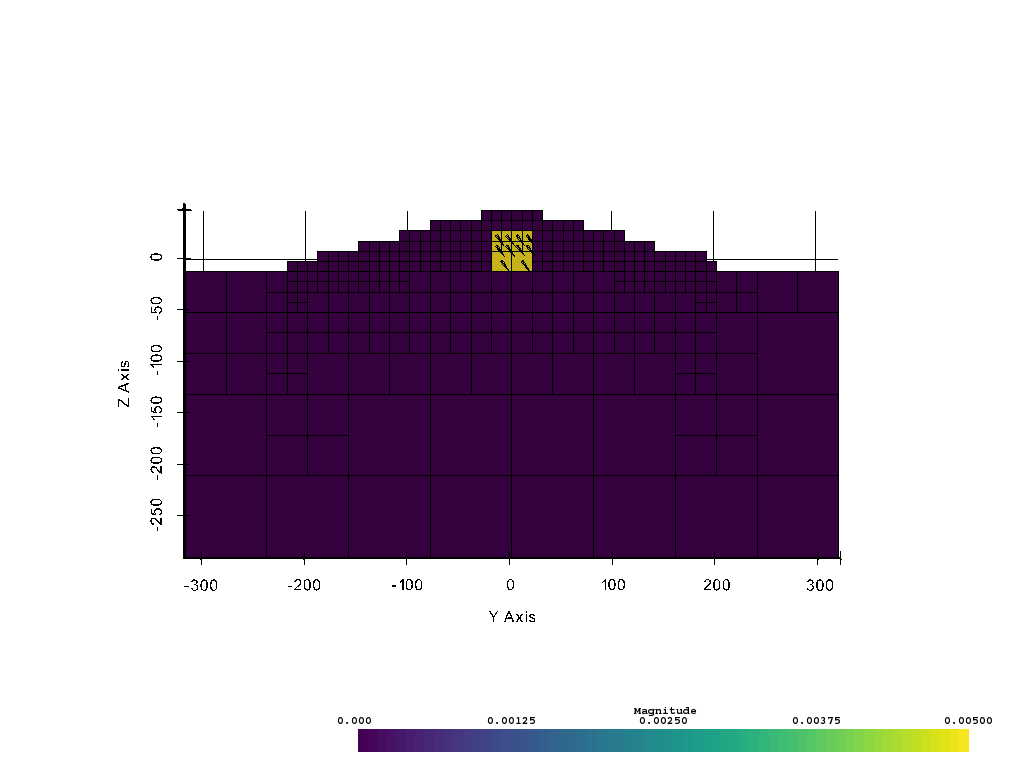

Finished exporting dataset to:  Slice.vtkjs


In [8]:
plotter = vtki.Plotter()
# plotter = vtki.BackgroundPlotter()
cpos = plotVtki(model, plotter, cam_position=[1,0,0], export='vtki')

# plotter = vtki.Plotter(shape=(1, 2))

# cpos = plotVtki(model,plotter.subplot(0,0), factor=3000, cam_position=[0,1,1], finalize=False)
# cpos = plotVtki(model,plotter.subplot(0,1), factor=3000, cam_position=[0,1,1])



In [9]:
# To view in browser, visit: http://viewer.pvgeo.org

# For sharable link, upload *.vtkjs to dropbox and get downloadable link, 
# Add link to function below
dropbox_link = 'https://www.dropbox.com/s/6pgxo6ehs7tns9z/figure-01.vtkjs?dl=0'
vtki.get_vtkjs_url(dropbox_link)


'http://viewer.pvgeo.org/?fileURL=https://dl.dropbox.com/s/6pgxo6ehs7tns9z/figure-01.vtkjs?dl=0'

In [10]:
# Compute linear forward operator and compute some data
data = prob.fields(Utils.mkvc(model)).compute()

std = 1.  #nT
wd = np.ones(len(data))*std
wd[1::2] *= 10

survey.dobs = data + np.random.randn(len(data))*wd
survey.std = wd

Begin forward: M=full, Rx type= tmi
DASK: 
Tile size (nD, nC):  (400, 33189)
Chunk sizes (nD, nC):  ((400,), (33189,))
Number of chunks:  1  x  1  =  1
Max chunk size (GB):  0.1062048
Max RAM (GB x CPU):  0.8496384
Saving G to zarr: ./sensitivity.zarr
[########################################] | 100% Completed |  3.1s


In [11]:
data


array([-1.88737512e+00, -1.95317483e+00, -1.96844649e+00, -1.92440164e+00,
       -1.82362628e+00, -1.68707442e+00, -1.55770755e+00, -1.49564838e+00,
       -1.56179953e+00, -1.79343510e+00, -2.18290162e+00, -2.67241335e+00,
       -3.17040682e+00, -3.58237553e+00, -3.84067464e+00, -3.91967535e+00,
       -3.83284378e+00, -3.61826086e+00, -3.32215381e+00, -2.98687458e+00,
       -1.95317483e+00, -1.95211291e+00, -1.85198009e+00, -1.63031685e+00,
       -1.28362846e+00, -8.44380558e-01, -3.94376397e-01, -6.14714324e-02,
        1.18423700e-02, -2.75807619e-01, -9.30431843e-01, -1.84413886e+00,
       -2.82880402e+00, -3.68614864e+00, -4.27581167e+00, -4.54735708e+00,
       -4.52959919e+00, -4.29609156e+00, -3.93051791e+00, -3.50475693e+00,
       -1.96844637e+00, -1.85198009e+00, -1.55110133e+00, -1.01138330e+00,
       -2.05503821e-01,  8.28660309e-01,  1.94807529e+00,  2.89333344e+00,
        3.34372425e+00,  3.04305172e+00,  1.93632340e+00,  2.26668715e-01,
       -1.69429898e+00, -

<IPython.core.display.Javascript object>


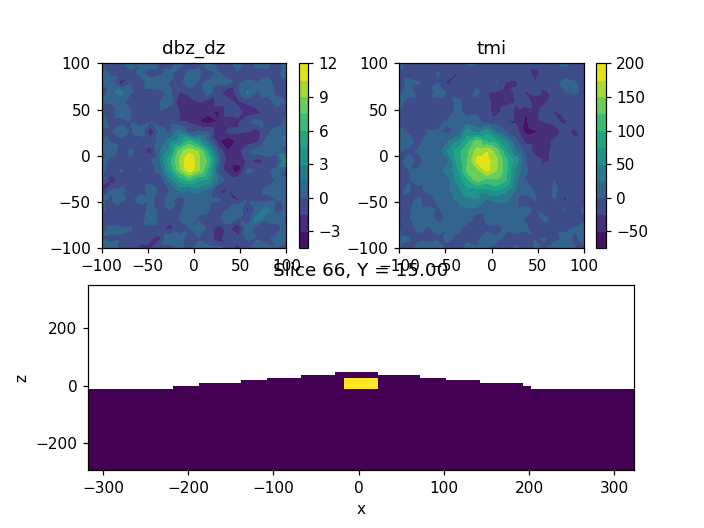

In [10]:
actvPlot = Maps.InjectActiveCells(mesh, actv, np.nan)
# Create a few models
plt.figure()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
for ii, comp in enumerate(survey.components):
    ax = plt.subplot(2,2,ii+1)
    im = Utils.PlotUtils.plot2Ddata(xyzLoc, survey.dobs[ii::len(survey.components)], ax=ax)
    plt.colorbar(im[0])
    ax.set_title(comp)
    plt.gca().set_aspect('equal', adjustable='box')


ax = plt.subplot(2,1,2)
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
mesh.plotSlice(actvPlot*np.sum(model**2, axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
# mesh.plot_3d_slicer(actvPlot*np.sum(model**2, axis=1)**0.5, transparent='slider', pcolorOpts={'cmap':'pink_r'})
plt.show()




**Run inversion in Cartesian space**

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Use Simple
Use Simple
Use Simple
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.94e+05  3.98e+03  5.98e-06  3.98e+03    1.57e+03      0              
Start CG solve
CG solve time: 11.153246879577637
   1  2.97e+05  5.93e+02  7.60e-04  8.18e+02    1.12e+03      0              
Start CG solve
CG solve time: 12.313016414642334
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.004502115129609805 eps_q: 0.004502115129609805
eps_p: 0.004423714562131708 eps_q: 0.004423714562131708
eps_p: 0.005813489967397863 eps_q: 0.005813489967397863
Reach maximum number of IRLS cycles: 0
------------------------- STOP! ---------

<IPython.core.display.Javascript object>


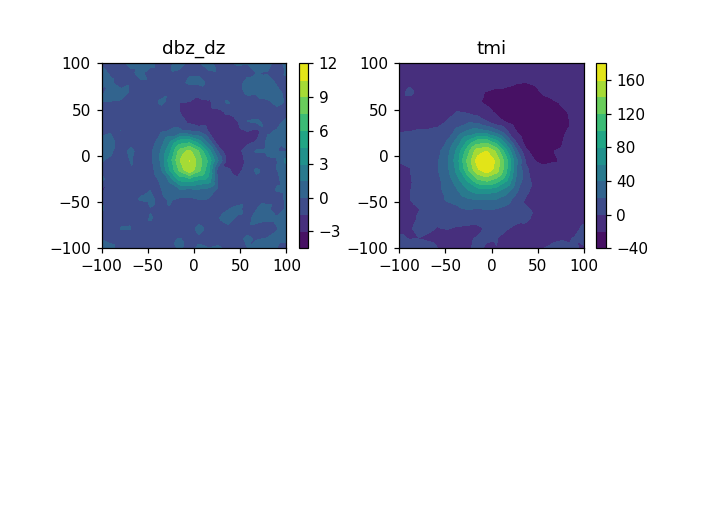

In [11]:
# Create sensitivity weights from our linear forward operator
rxLoc = survey.srcField.rxList[0].locs

# This Mapping connects all the regularizations together
wires = Maps.Wires(('p', nC), ('s', nC), ('t', nC))

# Create sensitivity weights from our linear forward operator
# so that all cells get equal chance to contribute to the solution
wr = prob.getJtJdiag(Utils.mkvc(model))**0.5
wr = (wr/np.max(wr))


# Create three regularization for the different components
# of magnetization
reg_p = Regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.cell_weights = (wires.p * wr)
reg_p.mref = np.zeros(3*nC)

reg_s = Regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.cell_weights = (wires.s * wr)
reg_s.mref = np.zeros(3*nC)

reg_t = Regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.cell_weights = (wires.t * wr)
reg_t.mref = np.zeros(3*nC)

reg = reg_p + reg_s + reg_t
reg.mref = np.zeros(3*nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-10, upper=10.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1e0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=0, beta_tol = 5e-1)
update_Jacobi = Directives.UpdatePreconditioner()

saveOuput = Directives.SaveOutputEveryIteration()
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi, betaest])

# Run the inversion
m0 = np.ones(3*nC)  * 1e-4# Starting model
mrec_MVIC = inv.run(m0)

beta = invProb.beta

plt.figure()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
for ii, comp in enumerate(survey.components):
    ax = plt.subplot(2,2,ii+1)
    im = Utils.PlotUtils.plot2Ddata(xyzLoc, invProb.dpred[ii::len(survey.components)], ax=ax)
    plt.colorbar(im[0])
    
    ax.set_title(comp)
    plt.gca().set_aspect('equal', adjustable='box')
    

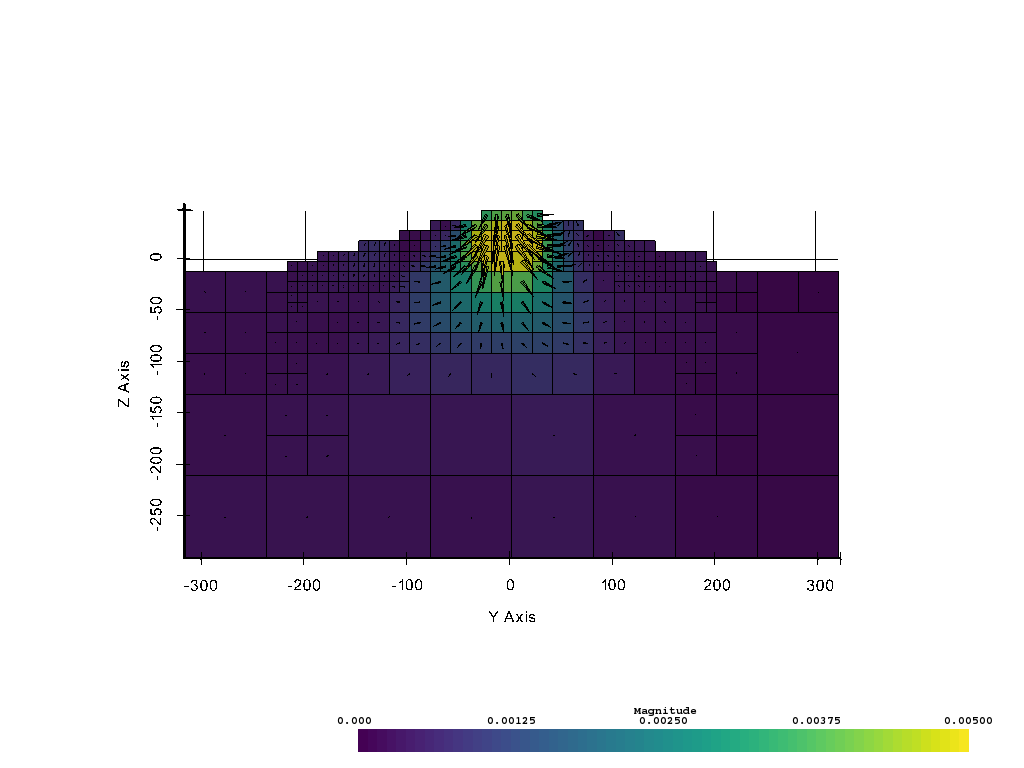

In [12]:
# PF.Magnetics.writeUBCobs('PredData.pre',survey,d=invProb.dpred)
# PF.Magnetics.writeUBCobs('ObsData.pre',survey)
plotter = vtki.Plotter()
plotVtki(invProb.model, plotter,factor=5000, cam_position=[1,0,0])



# Re-invert with TMI only

In [13]:
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField, components=["tmi"]) 

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(
    mesh, chiMap = idenMap, actInd = actv, modelType='vector'
)

# Pair the survey and problem
survey.pair(prob)

data = prob.fields(Utils.mkvc(model)).compute()

std = 10.  #nT
wd = np.ones(len(data))*std

survey.dobs = data + np.random.randn(len(data))*wd
survey.std = wd

# This Mapping connects all the regularizations together
wires = Maps.Wires(('p', nC), ('s', nC), ('t', nC))

# Create sensitivity weights from our linear forward operator
# so that all cells get equal chance to contribute to the solution
wr = prob.getJtJdiag(Utils.mkvc(model))**0.5
wr = (wr/np.max(wr))


# Create three regularization for the different components
# of magnetization
reg_p = Regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.cell_weights = (wires.p * wr)
reg_p.mref = np.zeros(3*nC)

reg_s = Regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.cell_weights = (wires.s * wr)
reg_s.mref = np.zeros(3*nC)

reg_t = Regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.cell_weights = (wires.t * wr)
reg_t.mref = np.zeros(3*nC)

reg = reg_p + reg_s + reg_t
reg.mref = np.zeros(3*nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-10, upper=10.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=0, beta_tol = 5e-1)
update_Jacobi = Directives.UpdatePreconditioner()

saveOuput = Directives.SaveOutputEveryIteration()
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi, betaest])

# Run the inversion
m0 = np.ones(3*nC)  * 1e-4# Starting model
mrec_TMI = inv.run(m0)

# beta = invProb.beta

Begin forward: M=full, Rx type= tmi
Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  400 33189
RAM/tile:  0.1062048
Total RAM (x n_cpu):  0.8496384
Zarr file detected with wrong shape and chunksize ... over-writting
Saving G to zarr: ./sensitivity.zarr
[########################################] | 100% Completed |  4.3s
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Use Simple
Use Simple
Use Simple
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.48e+07  3.06e+03  6.11e-06  3.39e+03    1.61e+03      0              
Start CG solve
CG solve time: 6.998042583465576
   1  2.74e+07  2.72e+03  6.70e-06  2.90e+03    1.55e+03      0              
Start CG solve
CG solve time: 7.077056646347046
   2  1.3

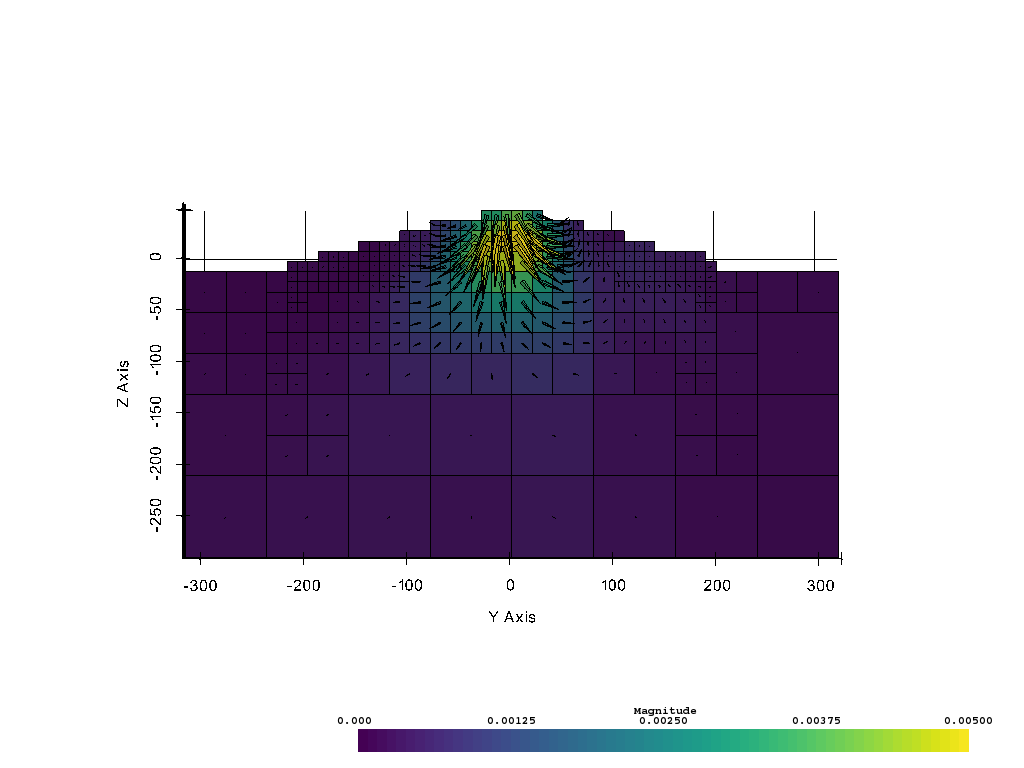

In [16]:
plotter = vtki.Plotter()
plotVtki(mrec_TMI, plotter,factor=8000, cam_position=[1,0,0])

**Continue run with Spherical formulaltion and sparsity**

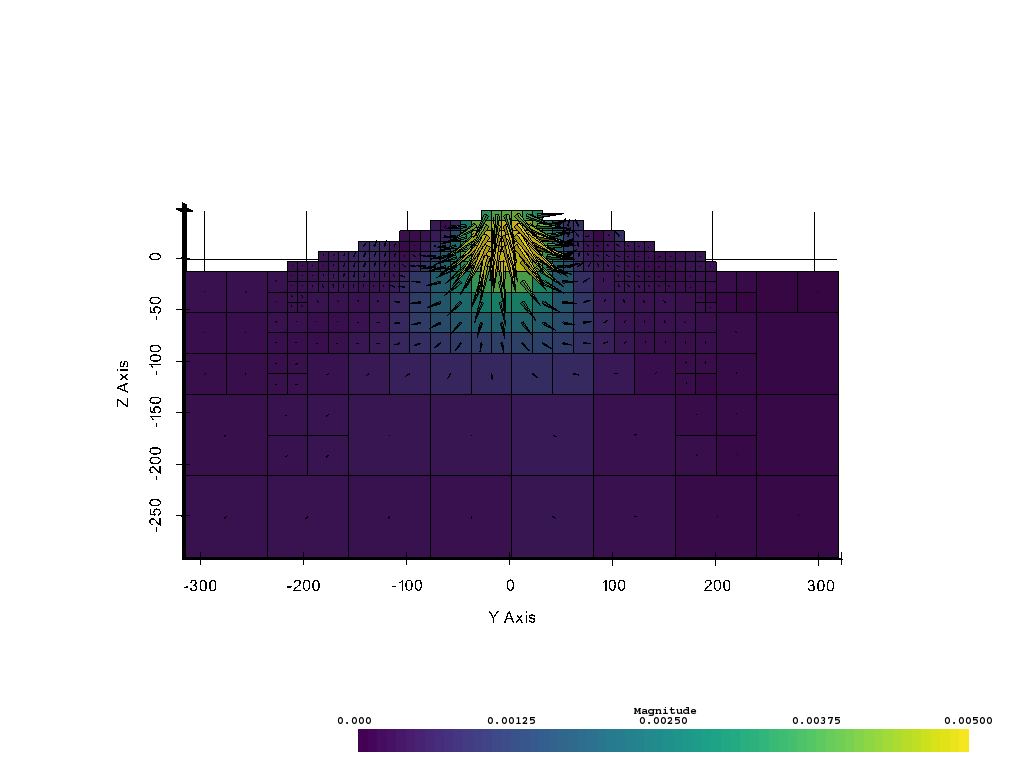

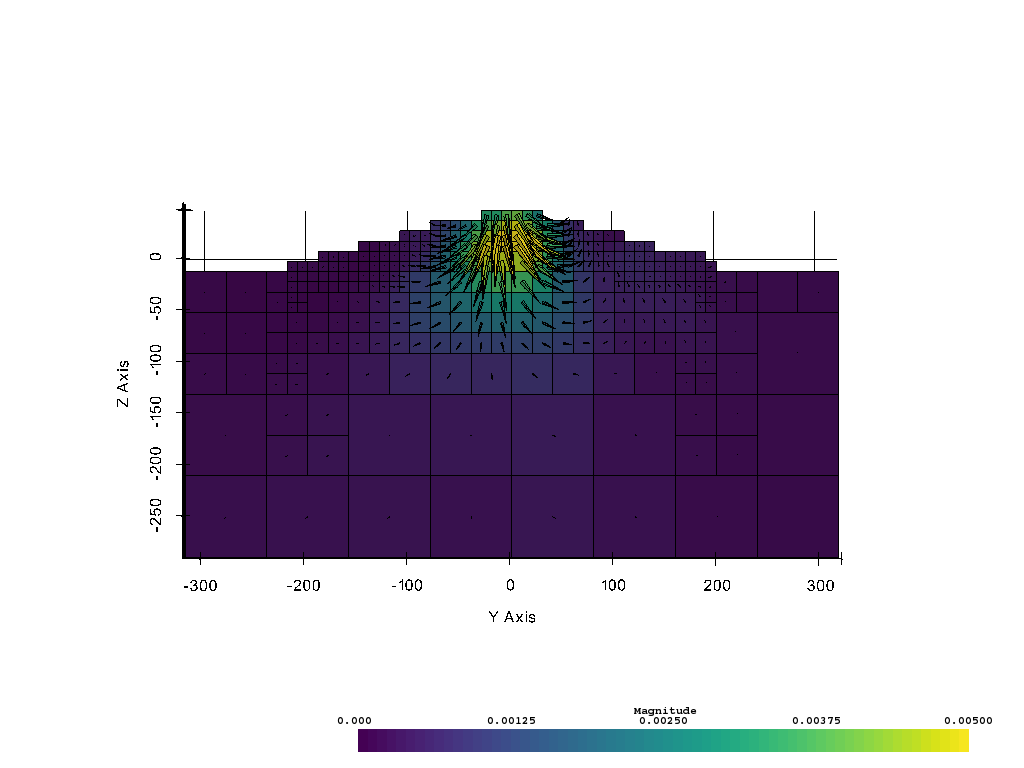

In [15]:
plotter = vtki.Plotter()
plotVtki(mrec_MVIC, plotter,factor=8000, cam_position=[1,0,0])

plotter = vtki.Plotter()
plotVtki(mrec_TMI, plotter,factor=8000, cam_position=[1,0,0])

In [ ]:
# mstart = Utils.matutils.xyz2atp(mrec_MVIC.reshape((nC,3),order='F'))

# dmis.prob.coordinate_system = 'spherical'
# dmis.prob.model = mstart

# # Create a block diagonal regularization
# wires = Maps.Wires(('amp', nC), ('theta', nC), ('phi', nC))

# # Create a regularization
# reg_a = Regularization.Sparse(mesh, indActive=actv,
#                               mapping=wires.amp)
# reg_a.norms = np.c_[0, 0., 0., 0.]
# reg_a.mref = np.zeros(3*nC)


# reg_t = Regularization.Sparse(mesh, indActive=actv,
#                               mapping=wires.theta)
# reg_t.alpha_s = 0.  # No reference angle
# reg_t.space = 'spherical'
# reg_t.norms = np.c_[2, 0, 0, 0]
# reg_t.eps_q = 2*np.pi

# # reg_t.alpha_x, reg_t.alpha_y, reg_t.alpha_z = 0.25, 0.25, 0.25

# reg_p = Regularization.Sparse(mesh, indActive=actv,
#                               mapping=wires.phi)
# reg_p.alpha_s = 0.  # No reference angle
# reg_p.space = 'spherical'
# reg_p.norms = np.c_[2, 0, 0, 0]
# reg_p.eps_q = 2*np.pi

# reg = reg_a + reg_t + reg_p
# reg.mref = np.zeros(3*nC)

# Lbound = np.kron(np.asarray([0, -np.inf, -np.inf]), np.ones(nC))
# Ubound = np.kron(np.asarray([10, np.inf, np.inf]), np.ones(nC))


# # Add directives to the inversion
# opt = Optimization.ProjectedGNCG(maxIter=40,
#                                  lower=Lbound,
#                                  upper=Ubound,
#                                  maxIterLS=10,
#                                  maxIterCG=30, tolCG=1e-3,
#                                  stepOffBoundsFact=1e-8,
#                                  )
# opt.approxHinv = None

# invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=beta*10.)
# #  betaest = Directives.BetaEstimate_ByEig()

# # Here is where the norms are applied
# IRLS = Directives.Update_IRLS(f_min_change=1e-4, maxIRLSiter=40,
#                               minGNiter=1, beta_tol = 0.5, prctile=98,
#                               coolingRate=1, coolEps_q=True,
#                               betaSearch=True)

# # Special directive specific to the mag amplitude problem. The sensitivity
# # weights are update between each iteration.
# ProjSpherical = Directives.ProjSpherical()
# update_SensWeight = Directives.UpdateSensitivityWeights()
# update_Jacobi = Directives.UpdatePreconditioner()

# inv = Inversion.BaseInversion(invProb,
#                               directiveList=[ProjSpherical, IRLS, update_SensWeight,
#                                              update_Jacobi])

# mrec_MVI_S = inv.run(mstart)

In [ ]:
from scipy.spatial import cKDTree


def plotVectors(model):
    
    axs.quiver(temp_mesh.gridCC[:, 0],
           temp_mesh.gridCC[:, 1],
           v2d[:, antiNormalInd[0]],
           v2d[:, antiNormalInd[1]],
           pivot='mid',
           scale_units="inches", scale=scale, linewidths=(1,),
           edgecolors=(vec),
           headaxislength=0.1, headwidth=10, headlength=30)


In [ ]:
plt.figure()
ax = plt.subplot(2,1,1)
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
mesh.plotSlice(actvPlot*np.sum(mrec_TMI.reshape((nC,3), order="F")**2., axis=1)**0.5, ax = ax, normal = 'Y', ind=65)
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_title('TMI')
ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

ax = plt.subplot(2,1,2)
# vec_atp = Utils.matutils.xyz2atp(mrec_MVIC.reshape((nC, 3), order='F')).reshape((nC, 3), order='F')
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
mesh.plotSlice(actvPlot*np.sum(mrec_MVIC.reshape((nC,3), order="F")**2., axis=1)**0.5, ax = ax, normal = 'Y', ind=65)
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
ax.set_title('TMI + dbz_dz')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')


# ax = plt.subplot(2,1,2)
# # out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
# plotVectorSectionsOctree(mesh, model.reshape((nC,3), order="F"), axs = ax, normal = 'Y', ind=65, actvMap = actvPlot, scale=0.1, vmin=0., vmax=0.01)
# ax.set_xlim([-200,200])
# ax.set_ylim([-100,75])
# ax.set_title('A simple block model.')
# ax.set_xlabel('x');ax.set_ylabel('y')
# plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
# plt.figure()
# ax = plt.subplot(1, 2, 1)
# Utils.PlotUtils.plot2Ddata(xyzLoc, invProb.dpred, ax=ax)
# ax.set_title('Predicted data.')
# plt.gca().set_aspect('equal', adjustable='box')

# ax = plt.subplot(1, 2, 2)
# Utils.PlotUtils.plot2Ddata(xyzLoc, data-invProb.dpred, ax=ax)
# ax.set_title('Data residual.')
# plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
mesh2D.

In [ ]:
components= [
    "dbx_dx", "dbx_dy", "dbx_dz", 
    "dby_dy", "dby_dz", "dbz_dz", 
    "bx", "by", "bz"]

X, Y = np.meshgrid(np.arange(-100,100,10), np.arange(-100,100,10))
Z = np.ones_like(X) * 100

xyzLoc = np.c_[X.reshape(-1), Y.reshape(-1), Z.reshape(-1)]
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField, components=components) 


# Define sphere at origin
R = 1. # meters
center = np.r_[0, 0, 0]
chi = 10.

dx = 0.1
nC = int(np.ceil(2*R/dx))


h=np.ones(nC)*dx

mesh = Mesh.TensorMesh([h, h, h], x0='CCC')

bsw = (mesh.gridCC - mesh.h_gridded/2.)
tne = (mesh.gridCC + mesh.h_gridded/2.)
xn1, xn2 = bsw[:, 0], tne[:, 0]
yn1, yn2 = bsw[:, 1], tne[:, 1]
zn1, zn2 = bsw[:, 2], tne[:, 2]

Yn = np.c_[mkvc(yn1), mkvc(yn2)]
Xn = np.c_[mkvc(xn1), mkvc(xn2)]
Zn = np.c_[mkvc(zn1), mkvc(zn2)]

model = np.zeros(mesh.nC)
ind = Utils.ModelBuilder.getIndicesSphere(center, R, mesh.gridCC)
model[ind] = chi

# mesh.plotSlice(model, ind = int(mesh.vnC[2]/2))
mesh.plotSlice(model)

idenMap = Maps.IdentityMap(nP=mesh.nC)
actv = np.ones(mesh.nC, dtype='bool')
prob = PF.Magnetics.MagneticIntegral(
    mesh, chiMap = idenMap, actInd = actv,
)

survey.pair(prob)

In [ ]:
b_xx.shape, data.shape[0]/9, X.shape







In [ ]:
data = prob.fields(model)
    
vScale = 4/3*np.pi*R**3 / np.sum(mesh.vol[ind])

b_xx = data[::9] * vScale
b_xy = data[1::9] * vScale
b_xz = data[2::9] * vScale
b_yy = data[3::9] * vScale
b_yz = data[4::9] * vScale
b_zz = data[5::9] * vScale
b_x =  data[6::9] * vScale
b_y =  data[7::9] * vScale
b_z =  data[8::9] * vScale

plt.figure(figsize=(8,8))

axs = plt.subplot(4,3,1)
im = plt.contourf(X, Y, b_xx.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[0])
plt.colorbar(im)

axs = plt.subplot(4,3,2)
im = plt.contourf(X, Y, b_xy.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[1])
plt.colorbar(im)

axs = plt.subplot(4,3,3)
im = plt.contourf(X, Y, b_xz.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[2])
plt.colorbar(im)

axs = plt.subplot(4,3,5)
im = plt.contourf(X, Y, b_yy.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[3])
plt.colorbar(im)

axs = plt.subplot(4,3,6)
im = plt.contourf(X, Y, b_yz.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[4])
plt.colorbar(im)

axs = plt.subplot(4,3,9)
im = plt.contourf(X, Y, b_zz.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[5])
plt.colorbar(im)

axs = plt.subplot(4,3,10)
im = plt.contourf(X, Y, b_x.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[6])
plt.colorbar(im)

axs = plt.subplot(4,3,11)
im = plt.contourf(X, Y, b_y.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[7])
plt.colorbar(im)

axs = plt.subplot(4,3,12)
im = plt.contourf(X, Y, b_z.reshape(X.shape))
axs.set_aspect('equal')
axs.set_title(components[8])
plt.colorbar(im)

In [ ]:
def getBGanalytic(rxLoc, center, R, H, chi):
    mx = np.ones(rxLoc.shape[0]) * H[0] * R**3 / 3 * chi
    my = np.ones(rxLoc.shape[0]) * H[1] * R**3 / 3 * chi
    mz = np.ones(rxLoc.shape[0]) * H[2] * R**3 / 3 * chi
    
    M = np.c_[mx, my, mz]

    dx = (rxLoc[:, 0] - center[0])
    dy = (rxLoc[:, 1] - center[1])
    dz = (rxLoc[:, 2] - center[2])

    rvec = np.c_[dx, dy, dz]
    r = np.sqrt((dx)**2+(dy)**2+(dz)**2)
    
    bxx = (
        3*mx*dx/r**5 + 
        3*mx*dx/r**5 + 
        3 * np.sum(M*rvec, axis=1)/r**5 +
        -15 * np.sum(M*rvec, axis=1)/r**7*dx**2.
    )

    byy = (
        3*my*dy/r**5 + 
        3*my/r**5*dy + 
        3 * np.sum(M*rvec, axis=1)/r**5 +
        -15 * np.sum(M*rvec, axis=1)/r**7*dy**2.
    )

    bzz = (
        3*mz*dz/r**5 + 
        3*mz/r**5*dz + 
        3 * np.sum(M*rvec, axis=1)/r**5 +
        -15 * np.sum(M*rvec, axis=1)/r**7*dz**2.
    )

    bxy = (
        3*mx*dy/r**5 + 
        3*my*dx/r**5 + 
        -15 * np.sum(M*rvec, axis=1)/r**7*dx*dy
    )

    bxz = (
        3*mx*dz/r**5 + 
        3*mz*dx/r**5 + 
        -15 * np.sum(M*rvec, axis=1)/r**7*dx*dz
    )

    byz = (
        3*my*dz/r**5 + 
        3*mz*dy/r**5 + 
        -15 * np.sum(M*rvec, axis=1)/r**7*dz*dy
    )
    
    return bxx, bxy, bxz, byy, byz, bzz




In [ ]:
# Inducing field
H = Utils.matutils.atp2xyz(np.c_[50000, -np.deg2rad(90), np.deg2rad(0)])

# Define sphere at origin
R = 1. # meters
center = np.r_[0, 0, 0]
chi = 10.

bxx, bxy, bxz, byy, byz, bzz = getBGanalytic(xyzLoc, center, R, H, chi)

plt.figure(figsize=(8,8))

axs = plt.subplot(3,3,1)
im = plt.contourf(X, Y, bxx.reshape(X.shape))
axs.set_aspect('equal')
plt.colorbar(im)

axs = plt.subplot(3,3,2)
im = plt.contourf(X, Y, bxy.reshape(X.shape))
axs.set_aspect('equal')
plt.colorbar(im)

axs = plt.subplot(3,3,3)
im = plt.contourf(X, Y, bxz.reshape(X.shape))
axs.set_aspect('equal')
plt.colorbar(im)

axs = plt.subplot(3,3,5)
im = plt.contourf(X, Y, byy.reshape(X.shape))
axs.set_aspect('equal')
plt.colorbar(im)

axs = plt.subplot(3,3,6)
im = plt.contourf(X, Y, byz.reshape(X.shape))
axs.set_aspect('equal')
plt.colorbar(im)

axs = plt.subplot(3,3,9)
im = plt.contourf(X, Y, bzz.reshape(X.shape))
axs.set_aspect('equal')
plt.colorbar(im)




# Script to export to vtki


In [ ]:
def plotVtki(model, plotter, factor=300, clim = [0., 0.005], cam_position=None, figName='Slice.png', finalize=True):
    arrow_geom = vtki.Arrow(tip_length=1)
    # arrow_geom = vtki.Cone()
    model.reshape((nC, 3), order="F").shape
    dataset = mesh.toVTK()

    vectors = np.empty((mesh.nC, 3))
    vectors[np.argwhere(actv).flatten(), :] = model.reshape((nC, 3), order="F")

    dataset.cell_arrays['Vectors'] = vectors
    dataset.cell_arrays['Magnitude'] = np.linalg.norm(vectors, axis=1)
    dataset.cell_arrays['Active'] = actv#np.load('active.npy').astype(int)
    dataset.active_scalar_name = 'Magnitude'
    dataset.active_vectors_name = 'Vectors'
    dataset = dataset.threshold(0.5, scalars='Active')

    # Get several slices of the mesh
    slices = dataset.slice_along_axis(n=5, axis='x')
    # Create arrows on those slices
    arrows = vtki.MultiBlock()
    for slc in slices:
        a = slc.cell_centers().glyph(orient=True, geom=arrow_geom, factor=factor)
        arrows.append(a)


    # Plot it up!
    d_params = dict(
        rng=clim,
        show_edges=True,
        cmap='viridis',
        scalars='Magnitude',
    )

     
    plotter.show_grid(all_edges=False,)

    # Add all the slices
    plotter.add_mesh(slices[2], name='slices', **d_params)
    # Add the vectors
    plotter.add_mesh(arrows[2], name='arrows', **d_params)

    # grid = vtki.PolyData(topo)
    # trian = grid.delauney_2d()

    # plotter = vtki.BackgroundPlotter()
    # plotter.add_mesh(trian)

    # Use a custom camera position
    if cam_position is not None:
#         print(cam_position)
        plotter.view_vector(cam_position)
    
    cpos = []
    if finalize:
    # View it!
        cpos = plotter.show(auto_close=False, )
        plotter.screenshot(figName)
        plotter.close()
    
    return cpos